1. Check sample document for Key Information Extraction (KIE) Task

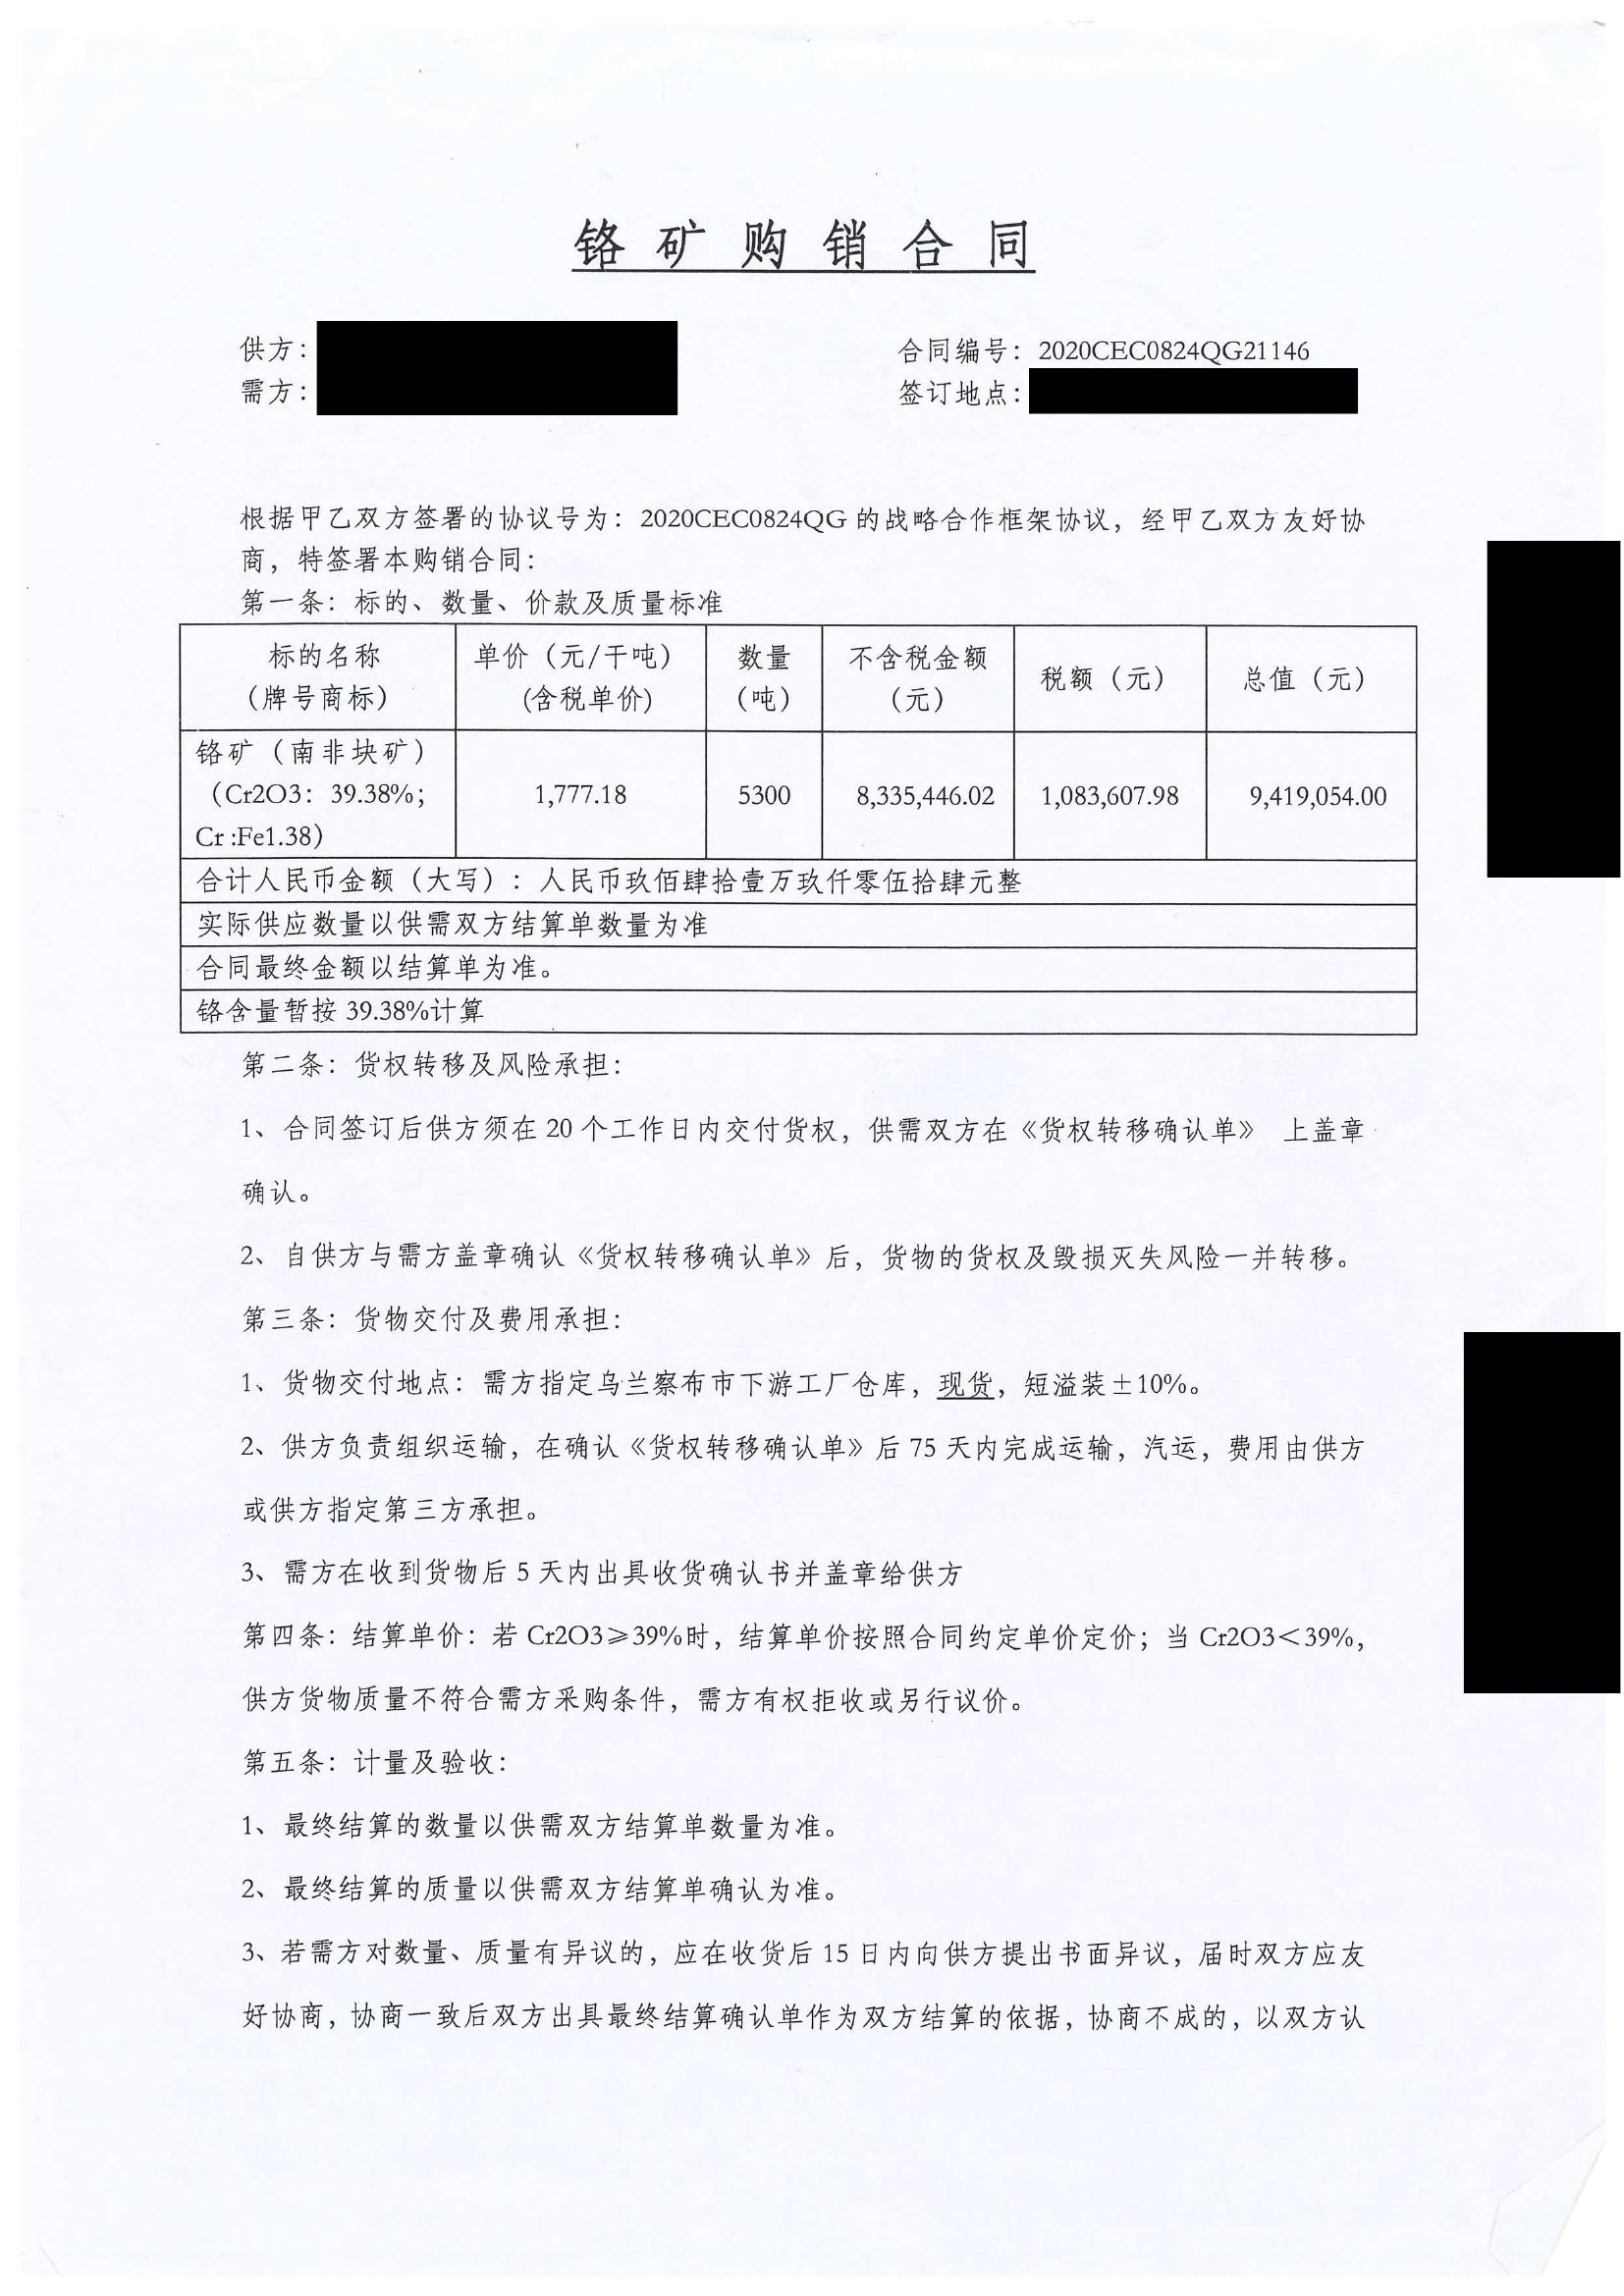

In [95]:
import cv2
from google.colab.patches import cv2_imshow
image = cv2.imread('/content/SampleContract.jpg')
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Here is the information attorneys would like to extract:

1. Contract No. 合同编号
2. Name of Product 标的名称（牌号商标）
3. Quantity 数量（吨）
4. Total Value 总值（元）

Based on the information extracted, attorneys would like to us to fill the draft pleading automatically.


2. Load the draft pleading for dcoument automation task & Visualize the draft pleading(2 pages) 

In [96]:
from pdf2image import convert_from_path
from pdf2image.exceptions import (
 PDFInfoNotInstalledError,
 PDFPageCountError,
 PDFSyntaxError
)
images = convert_from_path('/content/Draft Pealding.pdf')

for i, image in enumerate(images):
    fname = 'image'+str(i)+'.png'
    image.save(fname, "PNG")

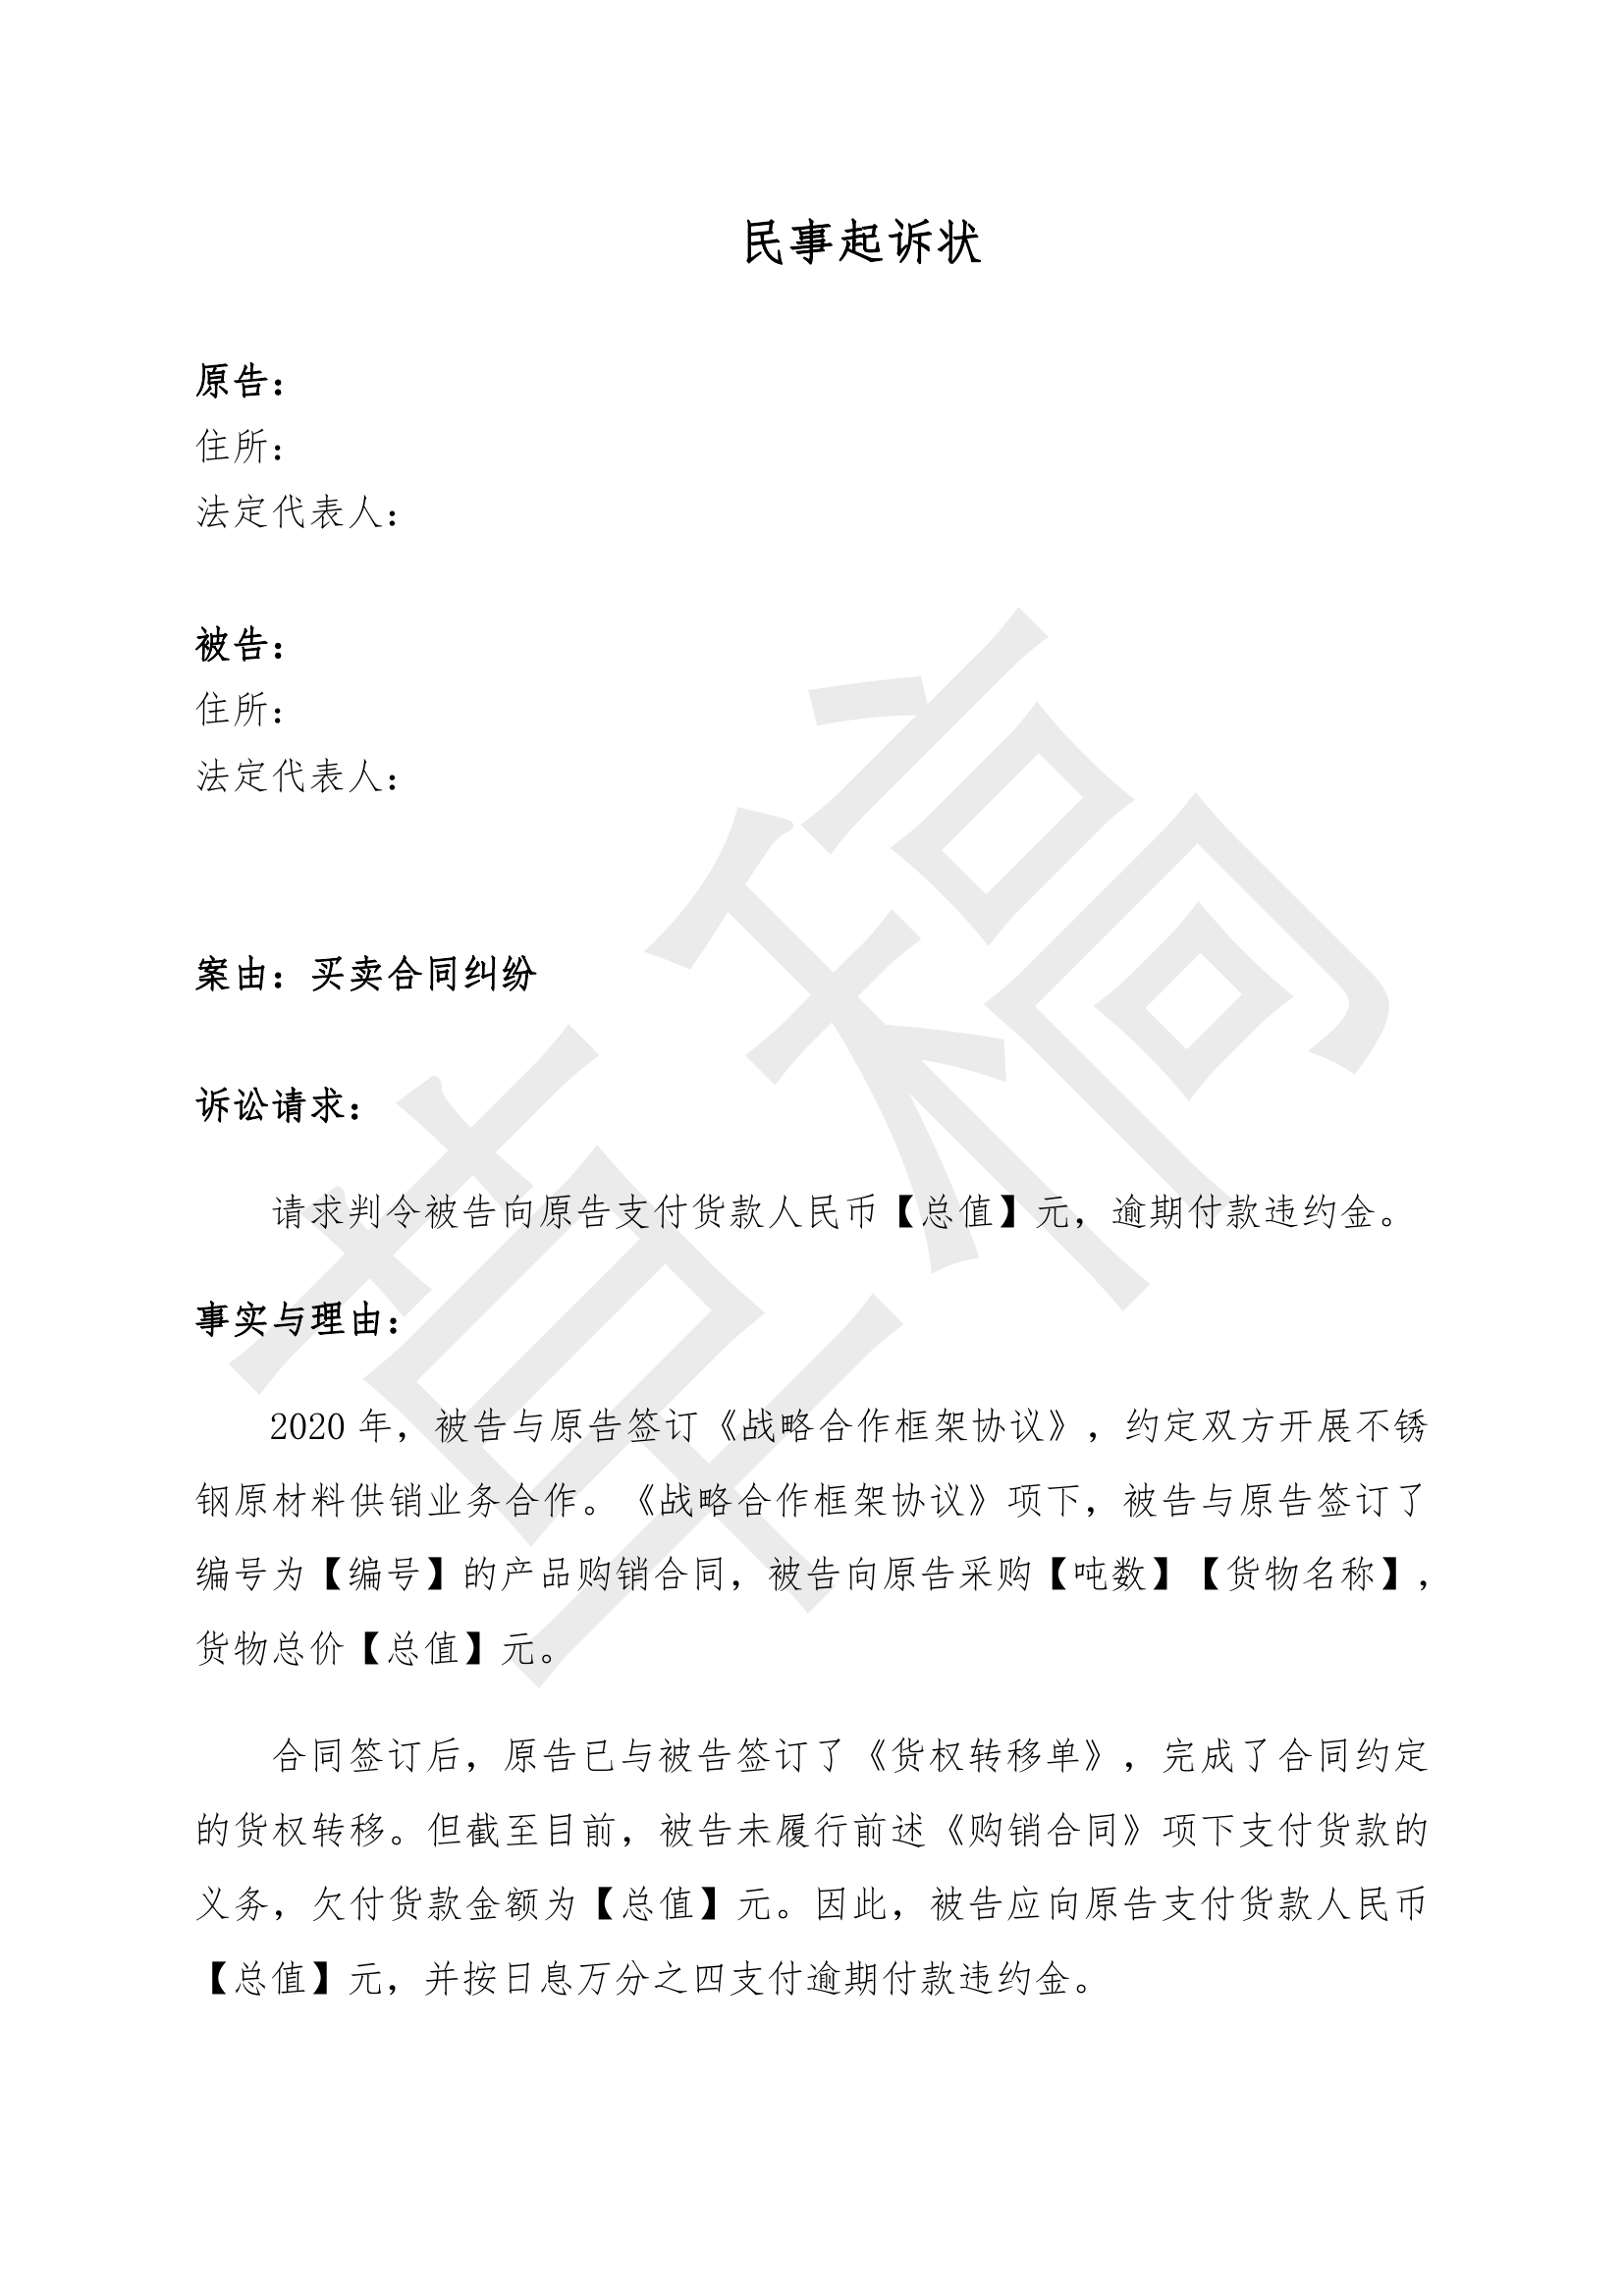

In [97]:
import cv2
from google.colab.patches import cv2_imshow
page1 = cv2.imread('/content/image0.png')
cv2_imshow(page1)
cv2.waitKey(0)
cv2.destroyAllWindows()

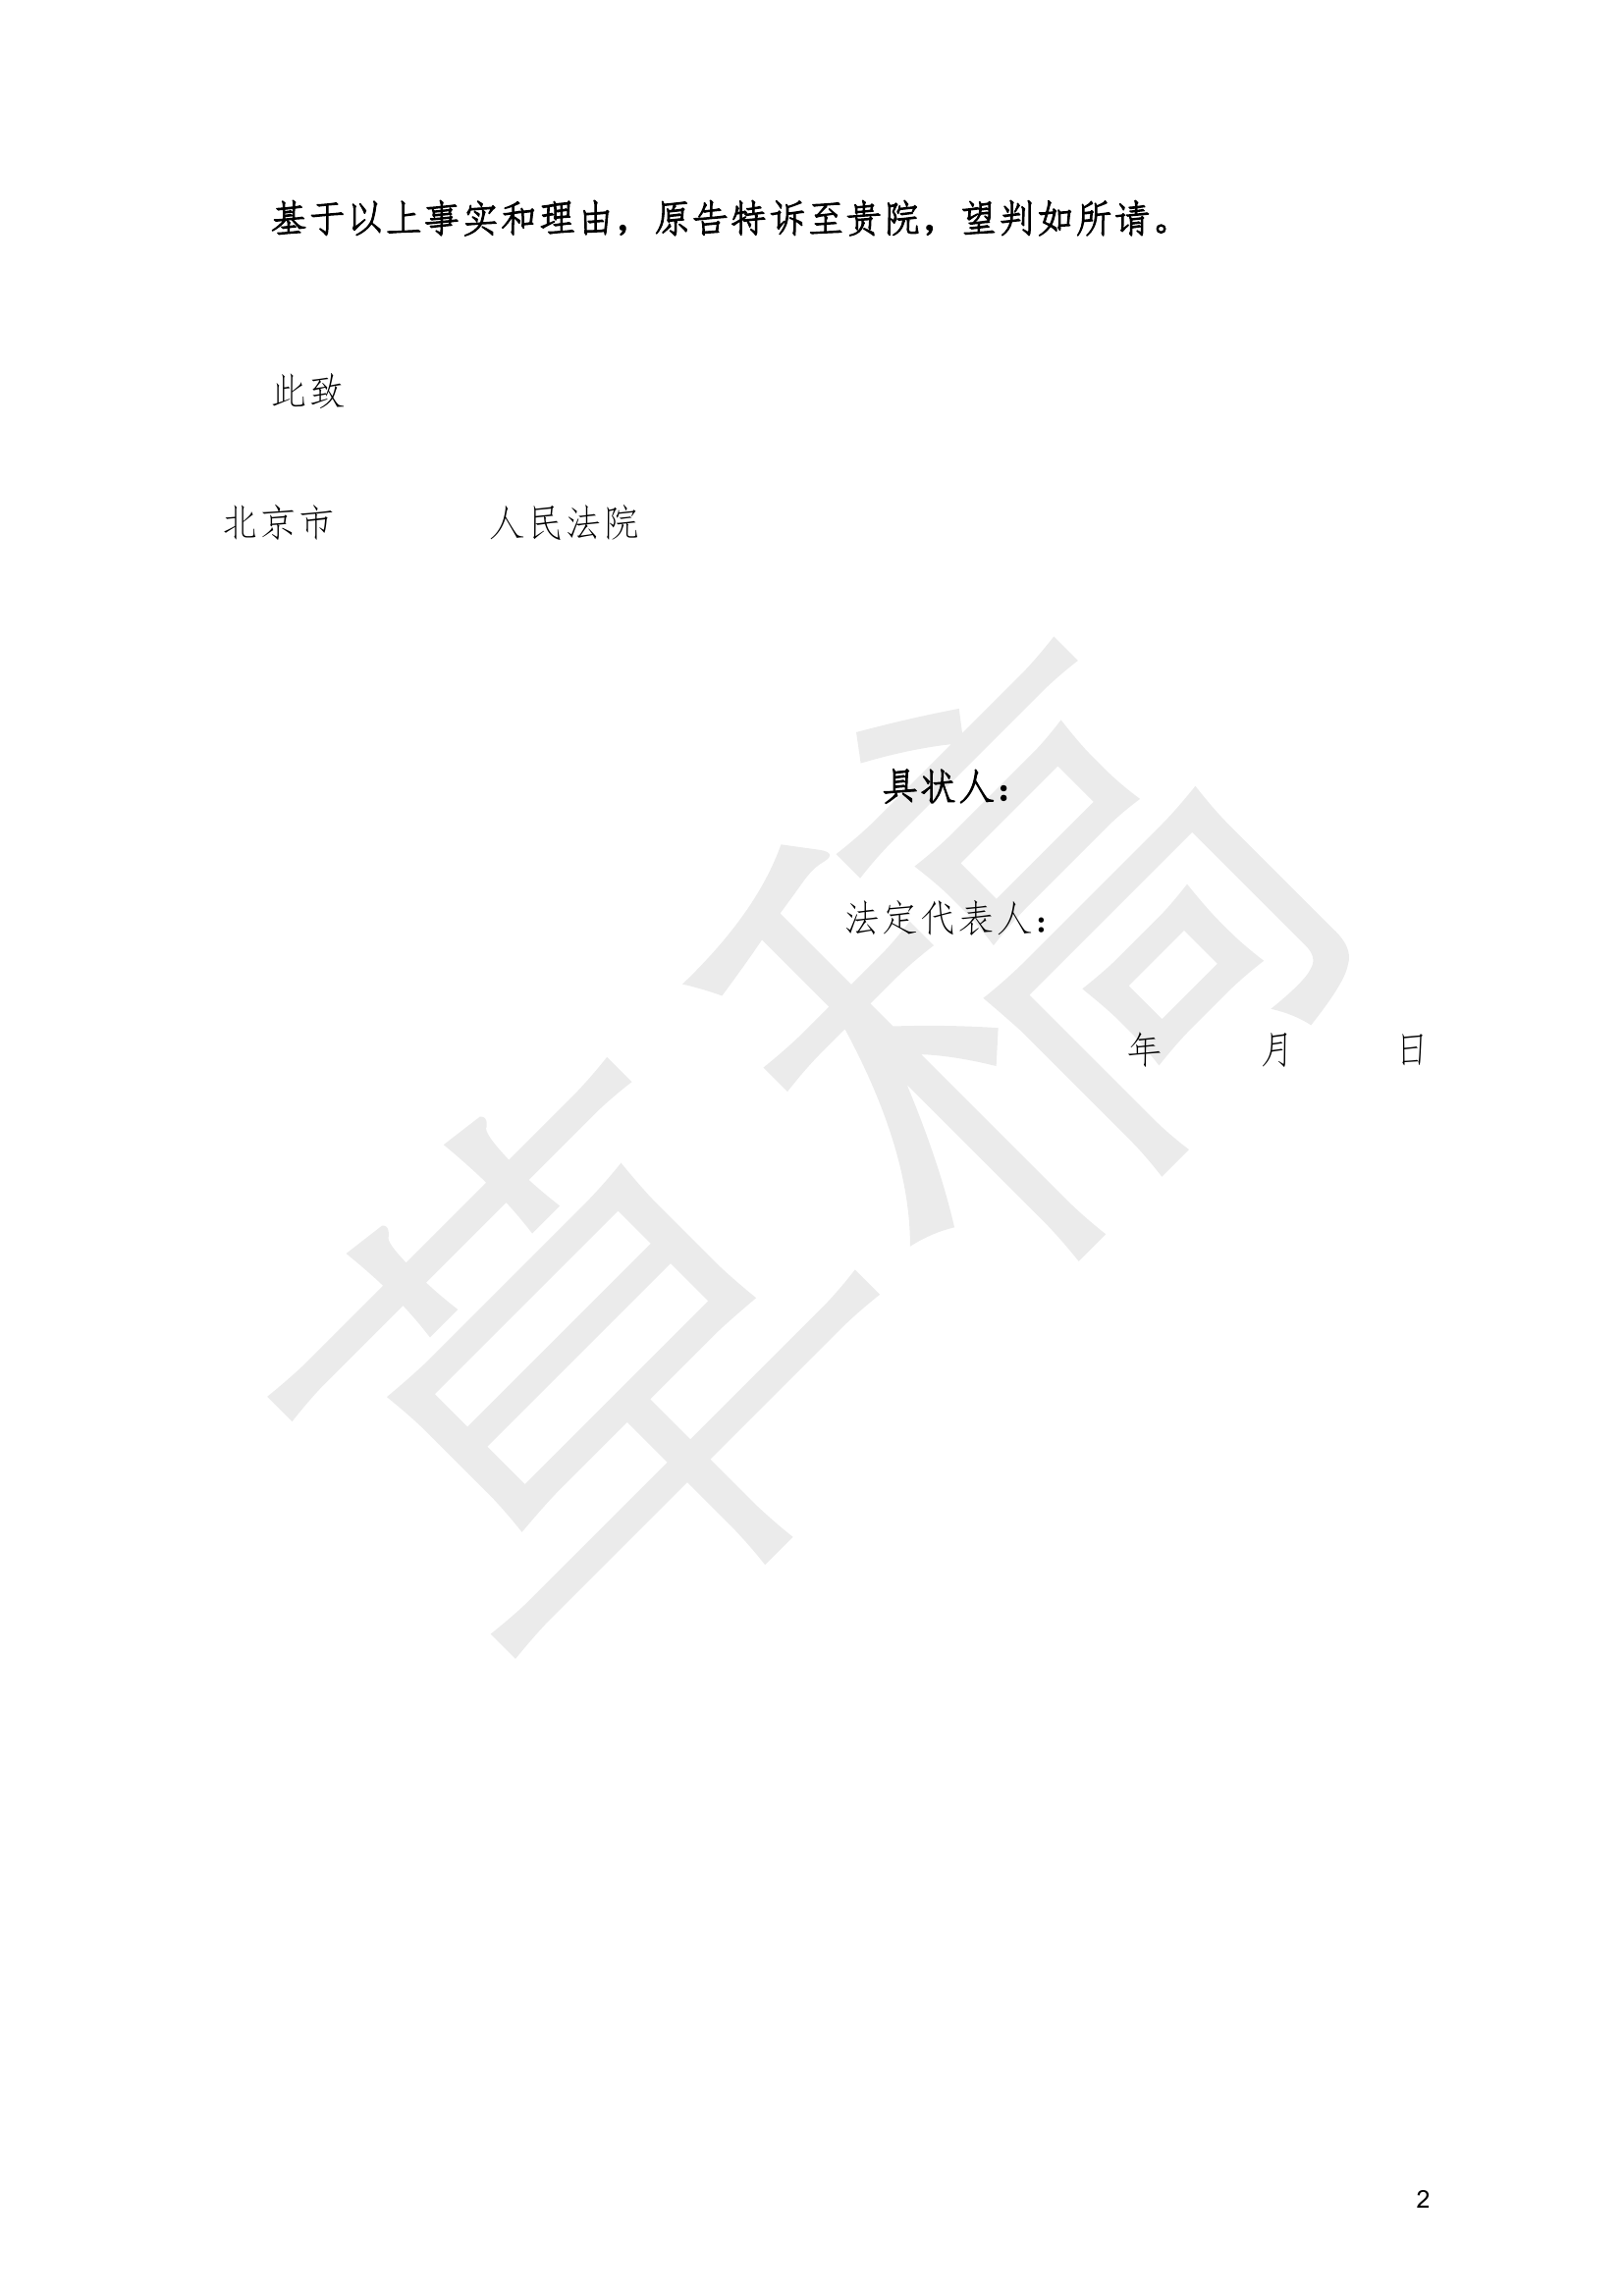

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
page2 = cv2.imread('/content/image1.png')
cv2_imshow(page2)
cv2.waitKey(0)
cv2.destroyAllWindows()

As we can vividly seen in the draft pleading, as soon as we get extracted data from the contract image, we can easily complete filling the 【】 blank with Key-Value pairs.

3. Set inference schema & Load pretrained model UIE-X-BASE for inference

In [98]:
from pprint import pprint
import paddlenlp
from paddlenlp import Taskflow
# set sechema
schema = ["合同编号","标的名称（牌号商标）","数量（吨）","总值（元）"]
# load pretrained model
ie = Taskflow("information_extraction", schema=schema, model="uie-x-base")

[2022-12-19 03:48:31,958] [    INFO] - We are using <class 'paddlenlp.transformers.ernie_layout.tokenizer.ErnieLayoutTokenizer'> to load '/root/.paddlenlp/taskflow/information_extraction/uie-x-base'.


4. Apply UIE-X-BASE model for inference

In [100]:
from paddlenlp.utils.doc_parser import DocParser
results = ie({"doc": "/content/SampleContract.jpg"})
DocParser.write_image_with_results(
        "/content/SampleContract.jpg",
        result=results[0],
        save_path="/content/results.png")

In [101]:
pprint(results)

[{'合同编号': [{'bbox': [[1004, 339, 1332, 370]],
            'end': 32,
            'probability': 0.9989372179453859,
            'start': 14,
            'text': '2020CEC0824QG21146'}],
  '总值（元）': [{'bbox': [[1270, 794, 1418, 828]],
             'end': 231,
             'probability': 0.9955252290557937,
             'start': 219,
             'text': '9,419,054.00'}],
  '数量（吨）': [{'bbox': [[746, 789, 810, 826]],
             'end': 195,
             'probability': 0.9942471779620448,
             'start': 191,
             'text': '5300'}],
  '标的名称（牌号商标）': [{'bbox': [[197, 746, 436, 780]],
                  'end': 168,
                  'probability': 0.9585671814766421,
                  'start': 160,
                  'text': '铬矿（南非块矿）'}]}]


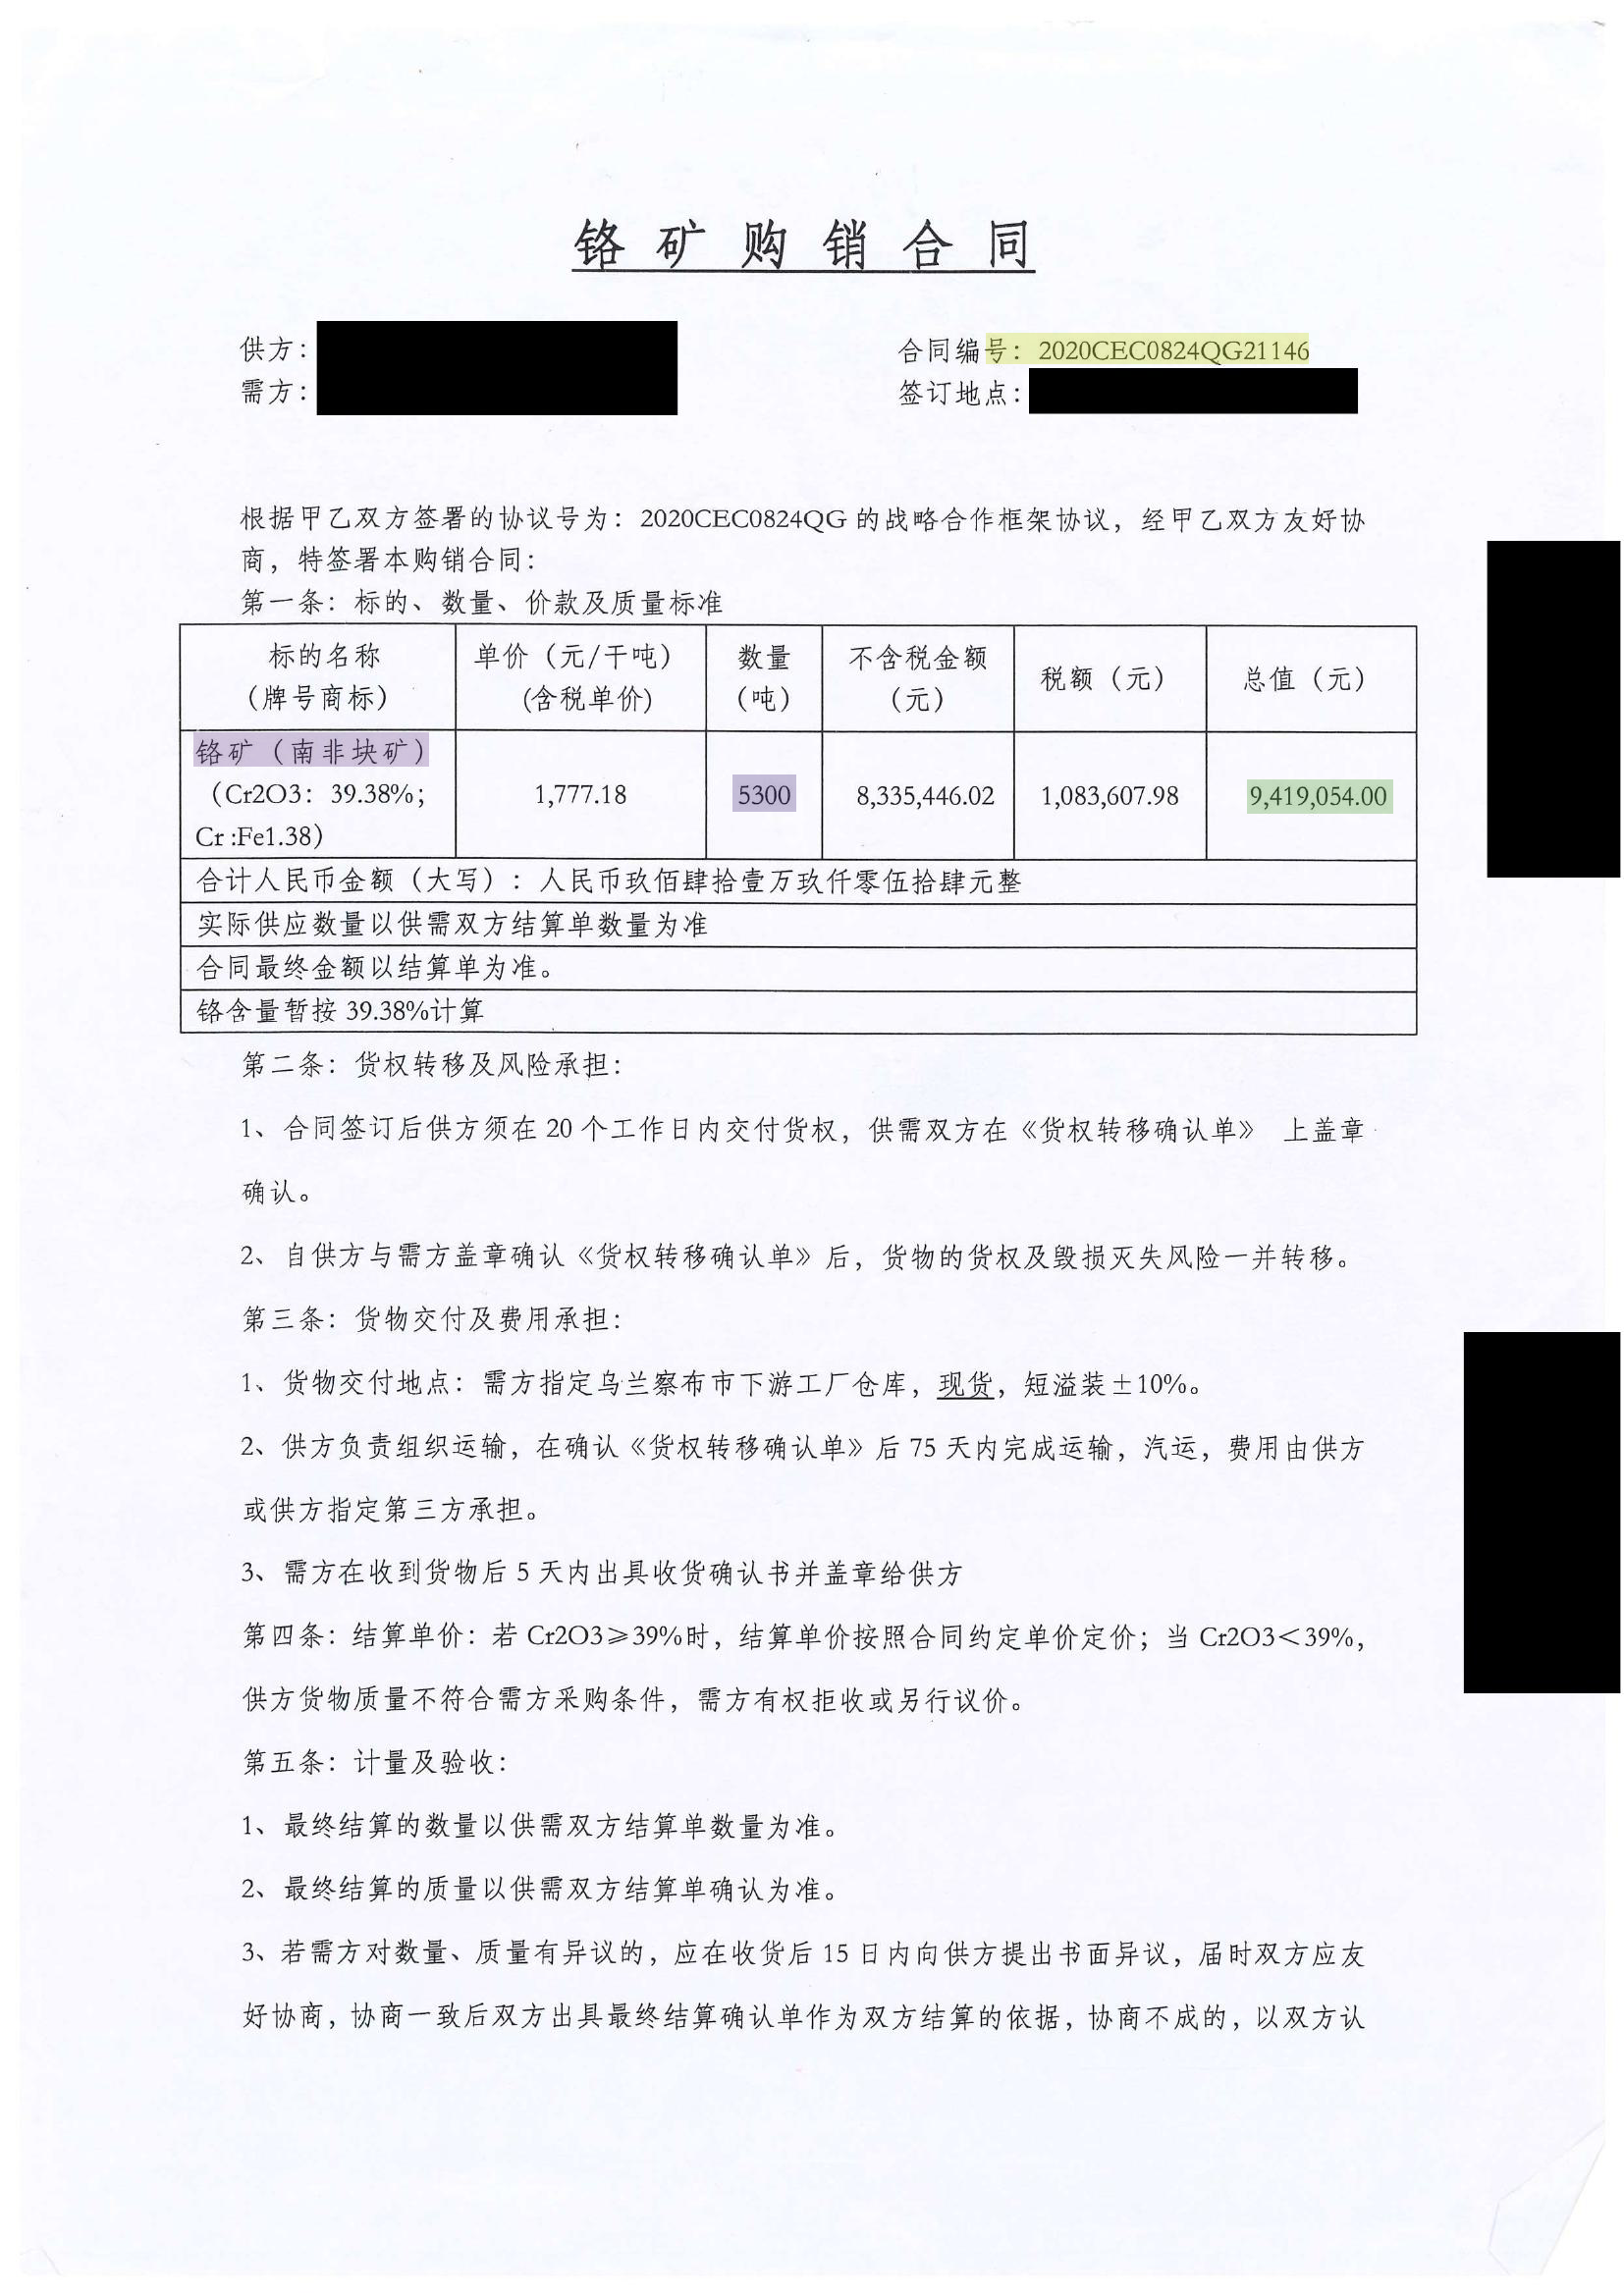

In [102]:
import cv2
from google.colab.patches import cv2_imshow
resultpage = cv2.imread('/content/results.png')
cv2_imshow(resultpage)
cv2.waitKey(0)
cv2.destroyAllWindows()

The results extracted in JSON & visualized in the original document seems pretty good! Now let's try to fill in those 【】s in the draft pleadings with the key information we extracted.

In [103]:
output = {}
for item in results:
    for key, value in item.items():
        output[key] = value[0]['text']
print(output)

{'合同编号': '2020CEC0824QG21146', '标的名称（牌号商标）': '铬矿（南非块矿）', '数量（吨）': '5300', '总值（元）': '9,419,054.00'}


In [104]:
output['编号'] = output.pop('合同编号')
output['货物名称'] = output.pop('标的名称（牌号商标）')
output['吨数'] = output.pop('数量（吨）')
output['吨数']=output['吨数']+ '吨'
output['总值'] = output.pop('总值（元）')
print(output)

{'编号': '2020CEC0824QG21146', '货物名称': '铬矿（南非块矿）', '吨数': '5300吨', '总值': '9,419,054.00'}


In [105]:
string = "2020年，被告与原告签订《战略合作框架协议》，约定双方开展不锈钢原材料供销业务合作。《战略合作框架协议》项下，被告与原告签订了编号为【编号】的产品购销合同，被告向原告采购【吨数】【货物名称】，货物总价【总值】元。"

for key, value in output.items():
    string = string.replace(f'【{key}】', value)

print(string)  # The string contains the keys value1 and value2

2020年，被告与原告签订《战略合作框架协议》，约定双方开展不锈钢原材料供销业务合作。《战略合作框架协议》项下，被告与原告签订了编号为2020CEC0824QG21146的产品购销合同，被告向原告采购5300吨铬矿（南非块矿），货物总价9,419,054.00元。


5. Pleading Automation

In [106]:
from docx import Document
import re
# Open the Word document
document = Document('/content/Pleadings Draft.docx')
# Define the dictionary with the key-value pairs
#data = {'编号': '2020CEC0824QG21146', '货物名称': '铬矿（南非块矿）', '吨数': '5300吨', '总值': '9,419,054.00'}
# Iterate through all the paragraphs in the document
for paragraph in document.paragraphs:
  for old_text, new_text in output.items():
    paragraph.text = paragraph.text.replace(f'【{old_text}】', new_text)
# Save the modified document
document.save('modified.docx')

In [ ]:
import aspose.words as aw
doc = aw.Document("/content/modified.docx")
doc.save("/content/output.pdf")

In [107]:
from pdf2image import convert_from_path
from pdf2image.exceptions import (
 PDFInfoNotInstalledError,
 PDFPageCountError,
 PDFSyntaxError
)
images = convert_from_path('/content/output.pdf')

for i, image in enumerate(images):
    fname = 'output'+str(i)+'.png'
    image.save(fname, "PNG")

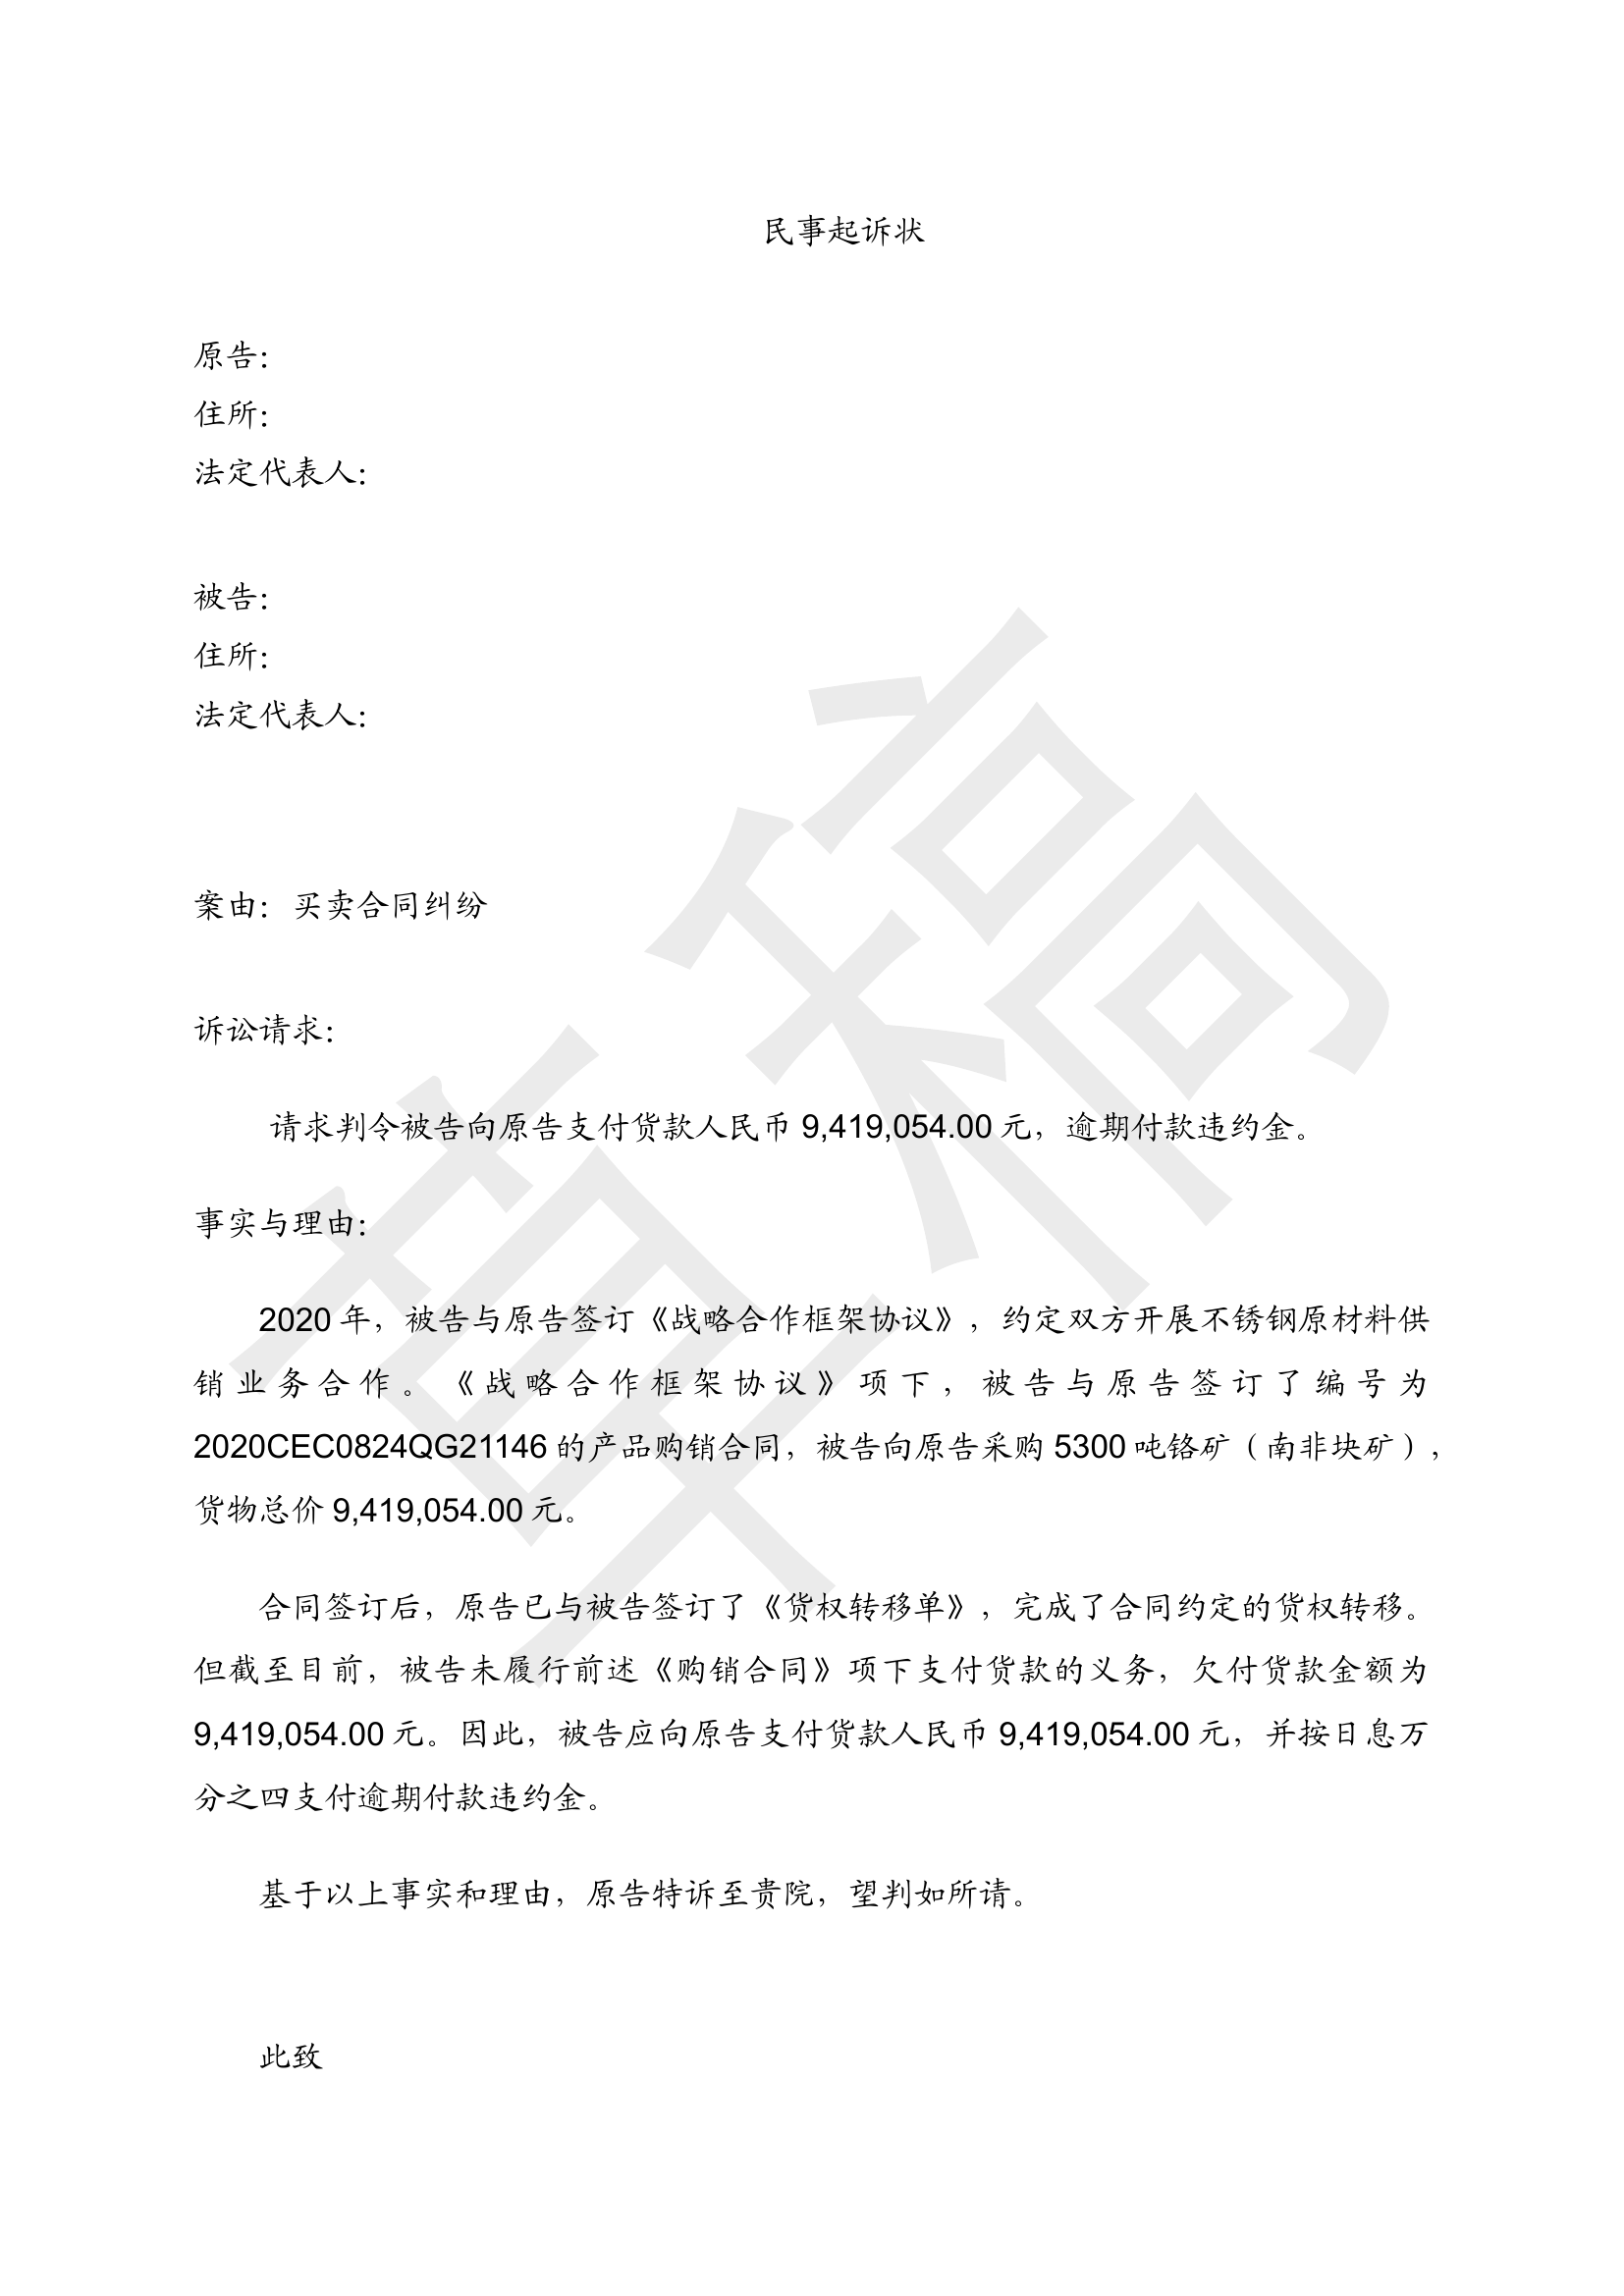

In [108]:
import cv2
from google.colab.patches import cv2_imshow
page1 = cv2.imread('/content/output0.png')
cv2_imshow(page1)
cv2.waitKey(0)
cv2.destroyAllWindows()

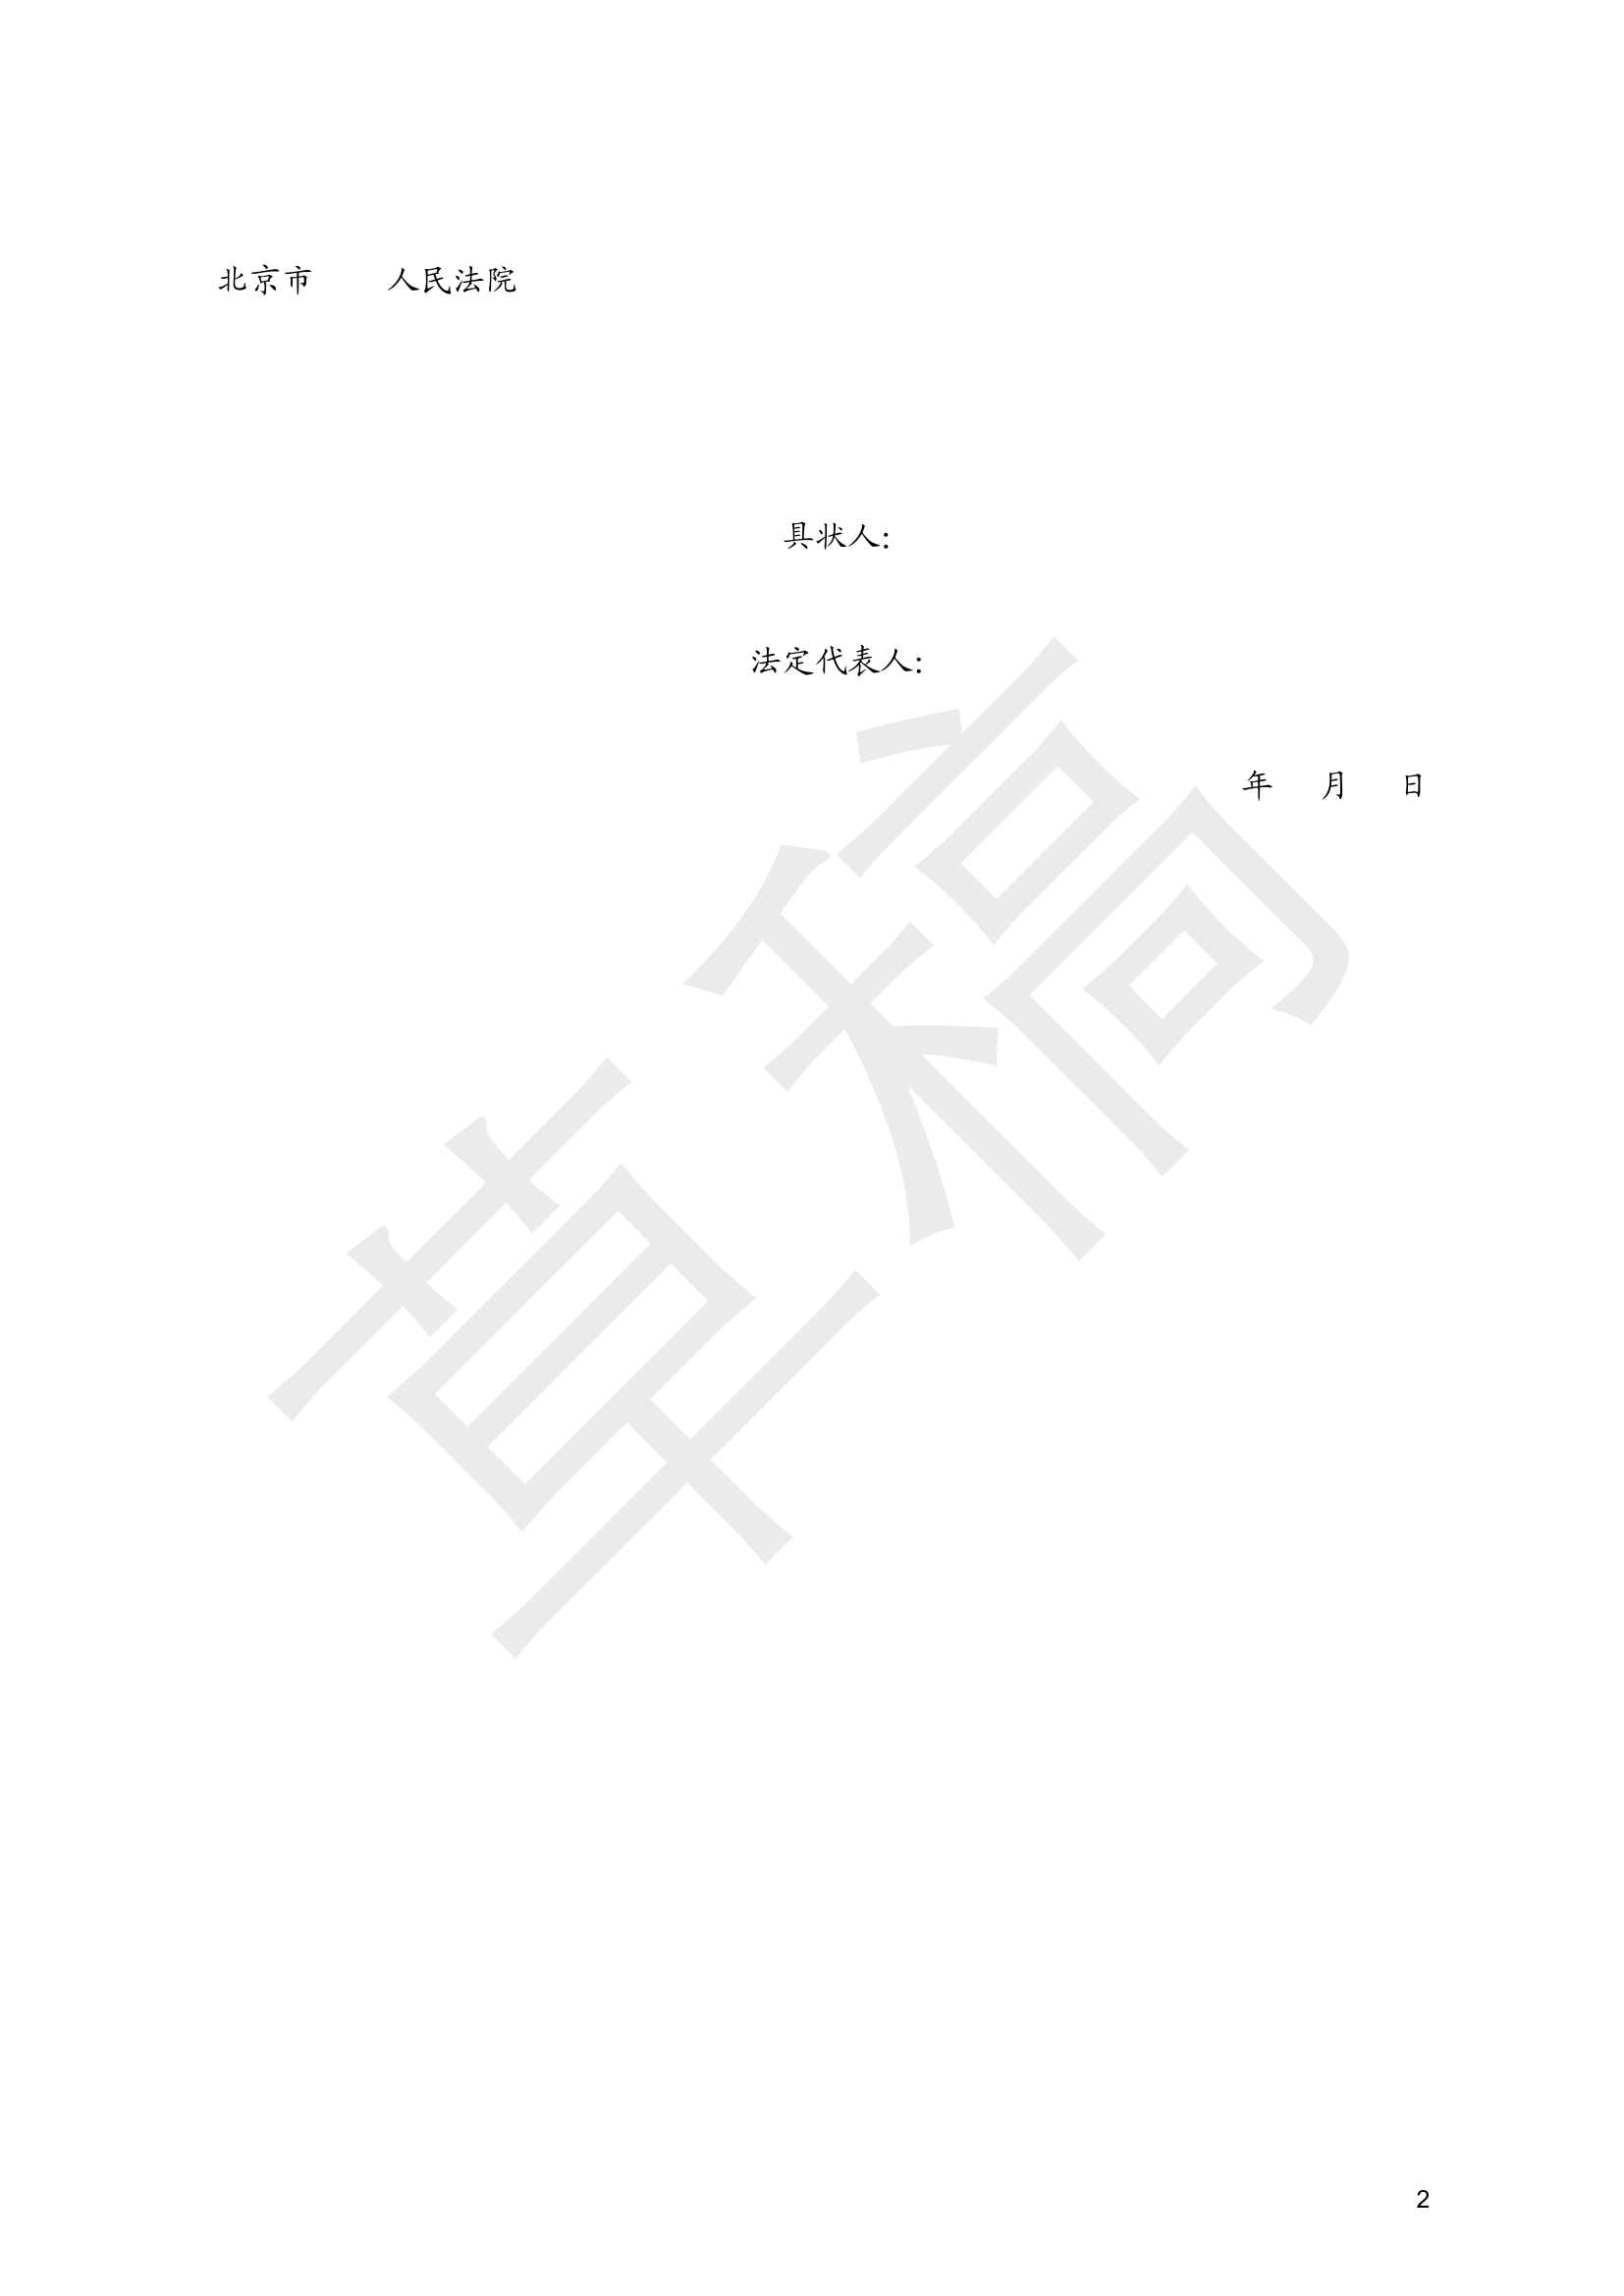

In [109]:
import cv2
from google.colab.patches import cv2_imshow
page1 = cv2.imread('/content/output1.png')
cv2_imshow(page1)
cv2.waitKey(0)
cv2.destroyAllWindows()